In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.utils.data_utils import get_file
from keras.layers import Input, Dense
import time
import numpy as np
from keras import backend as K
import audio_processor as ap
import pdb


##
def sort_result(tags, preds):
    result = zip(tags, preds)
    sorted_result = sorted(result, key=lambda x: x[1], reverse=True)
    return [(name, '%5.3f' % score) for name, score in sorted_result]

def librosa_exists():
    try:
        __import__('librosa')
    except ImportError:
        return False
    else:
        return True

c:\users\yizong\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
    audio_paths = ['data/bensound-cute.mp3',
                   'data/bensound-actionable.mp3',
                   'data/bensound-dubstep.mp3',
                   'data/bensound-thejazzpiano.mp3',
                  'data/Ballata1.mp3',
                  'data/chp_op31.mp3']
    melgram_paths = ['data/bensound-cute.npy',
                     'data/bensound-actionable.npy',
                     'data/bensound-dubstep.npy',
                     'data/bensound-thejazzpiano.npy',
                    'data/Ballata1.npy']

    tags = ['rock', 'pop', 'alternative', 'indie', 'electronic',
            'female vocalists', 'dance', '00s', 'alternative rock', 'jazz',
            'beautiful', 'metal', 'chillout', 'male vocalists',
            'classic rock', 'soul', 'indie rock', 'Mellow', 'electronica',
            '80s', 'folk', '90s', 'chill', 'instrumental', 'punk',
            'oldies', 'blues', 'hard rock', 'ambient', 'acoustic',
            'experimental', 'female vocalist', 'guitar', 'Hip-Hop',
            '70s', 'party', 'country', 'easy listening',
            'sexy', 'catchy', 'funk', 'electro', 'heavy metal',
            'Progressive rock', '60s', 'rnb', 'indie pop',
            'sad', 'House', 'happy']

    # prepare data like this
    melgrams = np.zeros((0, 1, 96, 1366))

    if librosa_exists:
        for audio_path in audio_paths:
            melgram = ap.compute_melgram(audio_path)
            melgrams = np.concatenate((melgrams, melgram), axis=0)
    else:
        for melgram_path in melgram_paths:
            melgram = np.load(melgram_path)
            melgrams = np.concatenate((melgrams, melgram), axis=0)
            
    melgrams = melgrams.transpose(0,2,3,1)
    TH_WEIGHTS_PATH = 'https://github.com/keunwoochoi/music-auto_tagging-keras/blob/master/data/music_tagger_cnn_weights_theano.h5'
    weights='msd'
    input_tensor=None
    include_top=True
    
    if weights not in {'msd', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `msd` '
                         '(pre-training on Million Song Dataset).')
    if K.image_dim_ordering() == 'th':
        input_shape = (1, 96, 1366)
    else:
        input_shape = (96, 1366, 1)

    if input_tensor is None:
        melgram_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            melgram_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            melgram_input = input_tensor
            
    if K.image_dim_ordering() == 'th':
        channel_axis = 1
        freq_axis = 2
        time_axis = 3
    else:
        channel_axis = 3
        freq_axis = 1
        time_axis = 2
        
    x = BatchNormalization(axis=freq_axis, name='bn_0_freq')(melgram_input)
    
    x = Convolution2D(32, 3, 3, border_mode='same', name='conv1')(x)
    x = BatchNormalization(axis=channel_axis, mode=0, name='bn1')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=(2, 4), name='pool1')(x)
    
    x = Convolution2D(64, 3, 3, border_mode='same', name='conv2')(x)
    x = BatchNormalization(axis=channel_axis, mode=0, name='bn2')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=(2, 4), name='pool2')(x)
    
    x = Convolution2D(64, 3, 3, border_mode='same', name='conv3')(x)
    x = BatchNormalization(axis=channel_axis, mode=0, name='bn3')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=(2, 4), name='pool3')(x)
    
    x = Convolution2D(64, 3, 3, border_mode='same', name='conv4')(x)
    x = BatchNormalization(axis=channel_axis, mode=0, name='bn4')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=(3, 5), name='pool4')(x)
    
    x = Convolution2D(32, 3, 3, border_mode='same', name='conv5')(x)
    x = BatchNormalization(axis=channel_axis, mode=0, name='bn5')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=(4, 4), name='pool5')(x)
    
    x = Flatten()(x)
    if include_top:
        x = Dense(50, activation='sigmoid', name='output')(x)
    model = Model(melgram_input, x)
    print (model)
    #model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    model.save('transfer_model.h5')
   
    
   # if weights is None:
   #   return model    
   # else: 
        # Load input
      #  if K.image_dim_ordering() == 'tf':
         #   raise RuntimeError("Please set image_dim_ordering == 'th'."
            #                   "You can set it at ~/.keras/keras.json")
           # model.load_weights('data/music_tagger_cnn_weights_%s.h5' % K._BACKEND,
                 #          by_name=True)
            

            # predict the tags like this
    print('Predicting...')
    start = time.time()
    pred_tags = model.predict(melgrams)
    # print like this...
  #  print "Prediction is done. It took %d seconds." % (time.time()-start)
    print('Printing top-10 tags for each track...')
    
    
    for song_idx, audio_path in enumerate(audio_paths):
        sorted_result = sort_result(tags, pred_tags[song_idx, :].tolist())
        print(audio_path)
        print(sorted_result[:5])
        print(sorted_result[5:10])
        print(' ')

c:\users\yizong\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), name="conv1", padding="same")`
c:\users\yizong\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:72: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=3, name="bn1")`
c:\users\yizong\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:76: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), name="conv2", padding="same")`
c:\users\yizong\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:77: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=3, name="bn2")`
c:\users\yizong\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:81: UserWarning: Update your `Conv2D` call to the Keras 2 API: `C

Predicting...
Printing top-10 tags for each track...
data/bensound-cute.mp3
[('country', '0.995'), ('catchy', '0.985'), ('dance', '0.980'), ('indie rock', '0.958'), ('alternative rock', '0.944')]
[('ambient', '0.939'), ('House', '0.938'), ('70s', '0.922'), ('electronic', '0.915'), ('rock', '0.893')]
 
data/bensound-actionable.mp3
[('country', '0.988'), ('dance', '0.977'), ('catchy', '0.971'), ('electronic', '0.967'), ('rock', '0.954')]
[('indie rock', '0.947'), ('House', '0.938'), ('alternative rock', '0.933'), ('easy listening', '0.908'), ('00s', '0.907')]
 
data/bensound-dubstep.mp3
[('country', '0.998'), ('dance', '0.994'), ('70s', '0.986'), ('indie rock', '0.986'), ('House', '0.980')]
[('alternative rock', '0.978'), ('catchy', '0.975'), ('ambient', '0.965'), ('rock', '0.965'), ('electronic', '0.957')]
 
data/bensound-thejazzpiano.mp3
[('country', '0.985'), ('dance', '0.954'), ('House', '0.954'), ('indie rock', '0.947'), ('rock', '0.942')]
[('catchy', '0.930'), ('electronic', '0.930

In [7]:
import glob

In [40]:
len(glob.glob("data/mini_test/*.mp3"))

20

In [37]:
melgrams_t = np.zeros((0, 1, 96, 1366))
for i in glob.glob("data/mini_test/*.mp3"):
    melgram_t = ap.compute_melgram(i)
    melgrams_t = np.concatenate((melgrams_t, melgram_t), axis=0)

In [43]:
melgrams_t = melgrams_t.transpose(0,2,3,1)

In [44]:
    pred_test = model.predict(melgrams_t)

In [50]:
    chopin_result = []
    other_result = []
    for song_idx, audio_path in enumerate(glob.glob("data/mini_test/*.mp3")):
        sorted_result = sort_result(tags, pred_test[song_idx, :].tolist())
        if song_idx < 11: 
            chopin_result.append(sorted_result)
        else:
            other_result.append(sorted_result)
        print(audio_path)
        print(sorted_result[:5])
        print(sorted_result[5:10])
        print(' ')

data/mini_test\Chopin - Andante spinato.mp3
[('00s', '0.995'), ('House', '0.986'), ('rock', '0.976'), ('heavy metal', '0.951'), ('punk', '0.933')]
[('Progressive rock', '0.912'), ('dance', '0.912'), ('alternative', '0.891'), ('indie rock', '0.891'), ('country', '0.886')]
 
data/mini_test\Chopin - Ballade in A flat major op.47 no.3.mp3
[('00s', '0.998'), ('House', '0.998'), ('punk', '0.990'), ('heavy metal', '0.987'), ('alternative', '0.987')]
[('rock', '0.977'), ('indie rock', '0.970'), ('Progressive rock', '0.959'), ('country', '0.958'), ('dance', '0.947')]
 
data/mini_test\Chopin - Ballade in F major op.38 No. 2.mp3
[('House', '0.997'), ('00s', '0.997'), ('punk', '0.991'), ('alternative', '0.986'), ('heavy metal', '0.984')]
[('rock', '0.977'), ('country', '0.960'), ('indie rock', '0.955'), ('70s', '0.954'), ('Progressive rock', '0.949')]
 
data/mini_test\Chopin - Ballade in G minor, op.23 no.1.mp3
[('House', '0.992'), ('00s', '0.991'), ('rock', '0.966'), ('heavy metal', '0.966'), ('c

In [20]:
import pandas as pd

In [28]:
d = {}

In [51]:
len(chopin_result)

11

In [64]:
chopin_result[0][1]

('House', '0.986')

In [65]:
d_t = {}

In [30]:
df = pd.DataFrame(data=d)

In [32]:
df["composer"] = "Chopin"

In [33]:
df

,00s,60s,70s,80s,90s,Hip-Hop,House,Mellow,Progressive rock,acoustic,...,oldies,party,pop,punk,rnb,rock,sad,sexy,soul,composer
0,0.992,0.351,0.911,0.107,0.573,0.140,0.993,0.429,0.920,0.004,...,0.115,0.148,0.005,0.965,0.096,0.962,0.419,0.759,0.646,Chopin


In [72]:
chopin_result[0][]

[('00s', '0.995'),
 ('House', '0.986'),
 ('rock', '0.976'),
 ('heavy metal', '0.951'),
 ('punk', '0.933'),
 ('Progressive rock', '0.912'),
 ('dance', '0.912'),
 ('alternative', '0.891'),
 ('indie rock', '0.891'),
 ('country', '0.886'),
 ('blues', '0.846'),
 ('female vocalist', '0.846'),
 ('sexy', '0.838'),
 ('70s', '0.823'),
 ('catchy', '0.821'),
 ('soul', '0.780'),
 ('electronic', '0.749'),
 ('chillout', '0.720'),
 ('indie', '0.645'),
 ('ambient', '0.643'),
 ('funk', '0.640'),
 ('easy listening', '0.607'),
 ('Mellow', '0.573'),
 ('beautiful', '0.540'),
 ('90s', '0.525'),
 ('male vocalists', '0.510'),
 ('electro', '0.444'),
 ('classic rock', '0.435'),
 ('metal', '0.423'),
 ('alternative rock', '0.419'),
 ('hard rock', '0.397'),
 ('60s', '0.358'),
 ('sad', '0.322'),
 ('folk', '0.305'),
 ('indie pop', '0.268'),
 ('chill', '0.218'),
 ('party', '0.183'),
 ('guitar', '0.180'),
 ('instrumental', '0.173'),
 ('80s', '0.169'),
 ('Hip-Hop', '0.165'),
 ('rnb', '0.108'),
 ('oldies', '0.107'),
 ('e

In [78]:
dict(chopin_result[0])

{'00s': '0.995',
 '60s': '0.358',
 '70s': '0.823',
 '80s': '0.169',
 '90s': '0.525',
 'Hip-Hop': '0.165',
 'House': '0.986',
 'Mellow': '0.573',
 'Progressive rock': '0.912',
 'acoustic': '0.009',
 'alternative': '0.891',
 'alternative rock': '0.419',
 'ambient': '0.643',
 'beautiful': '0.540',
 'blues': '0.846',
 'catchy': '0.821',
 'chill': '0.218',
 'chillout': '0.720',
 'classic rock': '0.435',
 'country': '0.886',
 'dance': '0.912',
 'easy listening': '0.607',
 'electro': '0.444',
 'electronic': '0.749',
 'electronica': '0.093',
 'experimental': '0.020',
 'female vocalist': '0.846',
 'female vocalists': '0.024',
 'folk': '0.305',
 'funk': '0.640',
 'guitar': '0.180',
 'happy': '0.013',
 'hard rock': '0.397',
 'heavy metal': '0.951',
 'indie': '0.645',
 'indie pop': '0.268',
 'indie rock': '0.891',
 'instrumental': '0.173',
 'jazz': '0.058',
 'male vocalists': '0.510',
 'metal': '0.423',
 'oldies': '0.107',
 'party': '0.183',
 'pop': '0.015',
 'punk': '0.933',
 'rnb': '0.108',
 'ro

In [92]:
df = pd.DataFrame(columns=tags)

In [76]:
df['Composer'] = ""

In [83]:
dict(chopin_result[0]).keys()

dict_keys(['00s', 'House', 'rock', 'heavy metal', 'punk', 'Progressive rock', 'dance', 'alternative', 'indie rock', 'country', 'blues', 'female vocalist', 'sexy', '70s', 'catchy', 'soul', 'electronic', 'chillout', 'indie', 'ambient', 'funk', 'easy listening', 'Mellow', 'beautiful', '90s', 'male vocalists', 'electro', 'classic rock', 'metal', 'alternative rock', 'hard rock', '60s', 'sad', 'folk', 'indie pop', 'chill', 'party', 'guitar', 'instrumental', '80s', 'Hip-Hop', 'rnb', 'oldies', 'electronica', 'jazz', 'female vocalists', 'experimental', 'pop', 'happy', 'acoustic'])

In [77]:
df

,rock,pop,alternative,indie,electronic,female vocalists,dance,00s,alternative rock,jazz,...,electro,heavy metal,Progressive rock,60s,rnb,indie pop,sad,House,happy,Composer


In [97]:
new_chopin = []

In [99]:
for i in range(len(chopin_result)):
    new_chopin.append(sorted(chopin_result[i]))

In [129]:
new_other = []
for i in range(len(other_result)):
    new_other.append(sorted(other_result[i]))

In [103]:
mus_index = []
for i in range(len(new_chopin[0])):
    mus_index.append(new_chopin[0][i][0])
    

In [104]:
mus_index 

['00s',
 '60s',
 '70s',
 '80s',
 '90s',
 'Hip-Hop',
 'House',
 'Mellow',
 'Progressive rock',
 'acoustic',
 'alternative',
 'alternative rock',
 'ambient',
 'beautiful',
 'blues',
 'catchy',
 'chill',
 'chillout',
 'classic rock',
 'country',
 'dance',
 'easy listening',
 'electro',
 'electronic',
 'electronica',
 'experimental',
 'female vocalist',
 'female vocalists',
 'folk',
 'funk',
 'guitar',
 'happy',
 'hard rock',
 'heavy metal',
 'indie',
 'indie pop',
 'indie rock',
 'instrumental',
 'jazz',
 'male vocalists',
 'metal',
 'oldies',
 'party',
 'pop',
 'punk',
 'rnb',
 'rock',
 'sad',
 'sexy',
 'soul']

In [ ]:
mus_rank = []
for i in range(len(new_chopin[0])):
    mus_rank.append(new_chopin[0][i][0])

In [ ]:
test_df = 

In [110]:
new_df['00s'][0]

('00s', '0.995')

In [111]:
new_df['00s'][0] = new_df['00s'][0][1]

In [114]:
new_df.shape[0]

11

In [120]:
new_df.keys()

Index(['00s', '60s', '70s', '80s', '90s', 'Hip-Hop', 'House', 'Mellow',
       'Progressive rock', 'acoustic', 'alternative', 'alternative rock',
       'ambient', 'beautiful', 'blues', 'catchy', 'chill', 'chillout',
       'classic rock', 'country', 'dance', 'easy listening', 'electro',
       'electronic', 'electronica', 'experimental', 'female vocalist',
       'female vocalists', 'folk', 'funk', 'guitar', 'happy', 'hard rock',
       'heavy metal', 'indie', 'indie pop', 'indie rock', 'instrumental',
       'jazz', 'male vocalists', 'metal', 'oldies', 'party', 'pop', 'punk',
       'rnb', 'rock', 'sad', 'sexy', 'soul'],
      dtype='object')

In [125]:
    for tag in new_df.keys():
        for num in range(new_df.shape[0]):
            new_df[tag][num] = new_df[tag][num][1]

In [131]:
other_df=pd.DataFrame(new_other, columns=mus_index)
for tag in other_df.keys():
    for num in range(other_df.shape[0]):
        other_df[tag][num] = other_df[tag][num][1]
other_df

,00s,60s,70s,80s,90s,Hip-Hop,House,Mellow,Progressive rock,acoustic,...,metal,oldies,party,pop,punk,rnb,rock,sad,sexy,soul
0,0.961,0.395,0.953,0.349,0.684,0.340,0.981,0.631,0.758,0.016,...,0.165,0.043,0.220,0.008,0.820,0.487,0.982,0.761,0.637,0.793
1,0.989,0.276,0.856,0.240,0.534,0.171,0.982,0.585,0.901,0.009,...,0.287,0.112,0.159,0.025,0.936,0.182,0.933,0.450,0.665,0.778
2,0.967,0.382,0.877,0.337,0.731,0.372,0.965,0.665,0.752,0.049,...,0.341,0.051,0.202,0.009,0.794,0.322,0.982,0.782,0.693,0.847
3,0.946,0.223,0.927,0.383,0.768,0.396,0.983,0.348,0.848,0.009,...,0.264,0.045,0.166,0.008,0.890,0.436,0.934,0.559,0.527,0.682
4,0.962,0.226,0.939,0.343,0.755,0.350,0.987,0.394,0.846,0.006,...,0.250,0.042,0.146,0.006,0.909,0.454,0.939,0.497,0.568,0.728
5,0.965,0.165,0.890,0.429,0.793,0.198,0.993,0.486,0.782,0.021,...,0.342,0.035,0.214,0.006,0.641,0.603,0.962,0.394,0.505,0.695
6,0.782,0.427,0.928,0.457,0.681,0.593,0.945,0.392,0.725,0.046,...,0.293,0.013,0.230,0.017,0.323,0.701,0.884,0.713,0.514,0.823
7,0.834,0.577,0.959,0.543,0.577,0.526,0.966,0.433,0.688,0.022,...,0.063,0.013,0.118,0.012,0.664,0.646,0.916,0.847,0.456,0.805
8,0.856,0.398,0.925,0.315,0.756,0.374,0.962,0.509,0.761,0.037,...,0.207,0.094,0.162,0.022,0.912,0.615,0.903,0.727,0.639,0.806


In [133]:
other_df["Composer"] = ["Other"]*other_df.shape[0]

In [134]:
other_df

,00s,60s,70s,80s,90s,Hip-Hop,House,Mellow,Progressive rock,acoustic,...,oldies,party,pop,punk,rnb,rock,sad,sexy,soul,Composer
0,0.961,0.395,0.953,0.349,0.684,0.340,0.981,0.631,0.758,0.016,...,0.043,0.220,0.008,0.820,0.487,0.982,0.761,0.637,0.793,Other
1,0.989,0.276,0.856,0.240,0.534,0.171,0.982,0.585,0.901,0.009,...,0.112,0.159,0.025,0.936,0.182,0.933,0.450,0.665,0.778,Other
2,0.967,0.382,0.877,0.337,0.731,0.372,0.965,0.665,0.752,0.049,...,0.051,0.202,0.009,0.794,0.322,0.982,0.782,0.693,0.847,Other
3,0.946,0.223,0.927,0.383,0.768,0.396,0.983,0.348,0.848,0.009,...,0.045,0.166,0.008,0.890,0.436,0.934,0.559,0.527,0.682,Other
4,0.962,0.226,0.939,0.343,0.755,0.350,0.987,0.394,0.846,0.006,...,0.042,0.146,0.006,0.909,0.454,0.939,0.497,0.568,0.728,Other
5,0.965,0.165,0.890,0.429,0.793,0.198,0.993,0.486,0.782,0.021,...,0.035,0.214,0.006,0.641,0.603,0.962,0.394,0.505,0.695,Other
6,0.782,0.427,0.928,0.457,0.681,0.593,0.945,0.392,0.725,0.046,...,0.013,0.230,0.017,0.323,0.701,0.884,0.713,0.514,0.823,Other
7,0.834,0.577,0.959,0.543,0.577,0.526,0.966,0.433,0.688,0.022,...,0.013,0.118,0.012,0.664,0.646,0.916,0.847,0.456,0.805,Other
8,0.856,0.398,0.925,0.315,0.756,0.374,0.962,0.509,0.761,0.037,...,0.094,0.162,0.022,0.912,0.615,0.903,0.727,0.639,0.806,Other


In [135]:
mix_df = new_df.append(other_df)

In [136]:
mix_df

,00s,60s,70s,80s,90s,Hip-Hop,House,Mellow,Progressive rock,acoustic,...,oldies,party,pop,punk,rnb,rock,sad,sexy,soul,Composer
0,0.995,0.358,0.823,0.169,0.525,0.165,0.986,0.573,0.912,0.009,...,0.107,0.183,0.015,0.933,0.108,0.976,0.322,0.838,0.780,Chopin
1,0.998,0.455,0.945,0.055,0.524,0.104,0.998,0.352,0.959,0.001,...,0.078,0.073,0.001,0.990,0.055,0.977,0.439,0.826,0.664,Chopin
2,0.997,0.452,0.954,0.079,0.567,0.151,0.997,0.344,0.949,0.001,...,0.079,0.094,0.001,0.991,0.055,0.977,0.506,0.807,0.636,Chopin
3,0.991,0.247,0.894,0.162,0.642,0.116,0.992,0.549,0.917,0.003,...,0.048,0.118,0.004,0.959,0.185,0.966,0.440,0.742,0.783,Chopin
4,0.992,0.351,0.911,0.107,0.573,0.140,0.993,0.429,0.920,0.004,...,0.115,0.148,0.005,0.965,0.096,0.962,0.419,0.759,0.646,Chopin
5,0.971,0.330,0.876,0.463,0.466,0.268,0.987,0.438,0.857,0.019,...,0.089,0.153,0.027,0.827,0.364,0.927,0.505,0.578,0.744,Chopin
6,0.885,0.256,0.949,0.271,0.787,0.211,0.997,0.335,0.932,0.002,...,0.031,0.096,0.004,0.967,0.511,0.928,0.612,0.588,0.754,Chopin
7,0.968,0.229,0.914,0.300,0.635,0.233,0.983,0.493,0.894,0.017,...,0.103,0.117,0.009,0.938,0.327,0.918,0.588,0.624,0.766,Chopin
8,0.982,0.245,0.879,0.311,0.541,0.186,0.983,0.553,0.910,0.013,...,0.109,0.121,0.016,0.906,0.303,0.934,0.497,0.646,0.830,Chopin
9,0.965,0.243,0.934,0.192,0.618,0.121,0.992,0.471,0.923,0.005,...,0.082,0.107,0.006,0.961,0.431,0.953,0.526,0.578,0.678,Chopin


In [126]:
new_df

,00s,60s,70s,80s,90s,Hip-Hop,House,Mellow,Progressive rock,acoustic,...,metal,oldies,party,pop,punk,rnb,rock,sad,sexy,soul
0,0.995,0.358,0.823,0.169,0.525,0.165,0.986,0.573,0.912,0.009,...,0.423,0.107,0.183,0.015,0.933,0.108,0.976,0.322,0.838,0.780
1,0.998,0.455,0.945,0.055,0.524,0.104,0.998,0.352,0.959,0.001,...,0.274,0.078,0.073,0.001,0.990,0.055,0.977,0.439,0.826,0.664
2,0.997,0.452,0.954,0.079,0.567,0.151,0.997,0.344,0.949,0.001,...,0.271,0.079,0.094,0.001,0.991,0.055,0.977,0.506,0.807,0.636
3,0.991,0.247,0.894,0.162,0.642,0.116,0.992,0.549,0.917,0.003,...,0.264,0.048,0.118,0.004,0.959,0.185,0.966,0.440,0.742,0.783
4,0.992,0.351,0.911,0.107,0.573,0.140,0.993,0.429,0.920,0.004,...,0.262,0.115,0.148,0.005,0.965,0.096,0.962,0.419,0.759,0.646
5,0.971,0.330,0.876,0.463,0.466,0.268,0.987,0.438,0.857,0.019,...,0.373,0.089,0.153,0.027,0.827,0.364,0.927,0.505,0.578,0.744
6,0.885,0.256,0.949,0.271,0.787,0.211,0.997,0.335,0.932,0.002,...,0.054,0.031,0.096,0.004,0.967,0.511,0.928,0.612,0.588,0.754
7,0.968,0.229,0.914,0.300,0.635,0.233,0.983,0.493,0.894,0.017,...,0.186,0.103,0.117,0.009,0.938,0.327,0.918,0.588,0.624,0.766
8,0.982,0.245,0.879,0.311,0.541,0.186,0.983,0.553,0.910,0.013,...,0.259,0.109,0.121,0.016,0.906,0.303,0.934,0.497,0.646,0.830
9,0.965,0.243,0.934,0.192,0.618,0.121,0.992,0.471,0.923,0.005,...,0.120,0.082,0.107,0.006,0.961,0.431,0.953,0.526,0.578,0.678


In [127]:
new_df["Composer"] = ["Chopin"]*11

In [128]:
new_df

,00s,60s,70s,80s,90s,Hip-Hop,House,Mellow,Progressive rock,acoustic,...,oldies,party,pop,punk,rnb,rock,sad,sexy,soul,Composer
0,0.995,0.358,0.823,0.169,0.525,0.165,0.986,0.573,0.912,0.009,...,0.107,0.183,0.015,0.933,0.108,0.976,0.322,0.838,0.780,Chopin
1,0.998,0.455,0.945,0.055,0.524,0.104,0.998,0.352,0.959,0.001,...,0.078,0.073,0.001,0.990,0.055,0.977,0.439,0.826,0.664,Chopin
2,0.997,0.452,0.954,0.079,0.567,0.151,0.997,0.344,0.949,0.001,...,0.079,0.094,0.001,0.991,0.055,0.977,0.506,0.807,0.636,Chopin
3,0.991,0.247,0.894,0.162,0.642,0.116,0.992,0.549,0.917,0.003,...,0.048,0.118,0.004,0.959,0.185,0.966,0.440,0.742,0.783,Chopin
4,0.992,0.351,0.911,0.107,0.573,0.140,0.993,0.429,0.920,0.004,...,0.115,0.148,0.005,0.965,0.096,0.962,0.419,0.759,0.646,Chopin
5,0.971,0.330,0.876,0.463,0.466,0.268,0.987,0.438,0.857,0.019,...,0.089,0.153,0.027,0.827,0.364,0.927,0.505,0.578,0.744,Chopin
6,0.885,0.256,0.949,0.271,0.787,0.211,0.997,0.335,0.932,0.002,...,0.031,0.096,0.004,0.967,0.511,0.928,0.612,0.588,0.754,Chopin
7,0.968,0.229,0.914,0.300,0.635,0.233,0.983,0.493,0.894,0.017,...,0.103,0.117,0.009,0.938,0.327,0.918,0.588,0.624,0.766,Chopin
8,0.982,0.245,0.879,0.311,0.541,0.186,0.983,0.553,0.910,0.013,...,0.109,0.121,0.016,0.906,0.303,0.934,0.497,0.646,0.830,Chopin
9,0.965,0.243,0.934,0.192,0.618,0.121,0.992,0.471,0.923,0.005,...,0.082,0.107,0.006,0.961,0.431,0.953,0.526,0.578,0.678,Chopin


In [123]:
new_df = pd.DataFrame(new_chopin, columns=mus_index)

In [106]:
new_df

,00s,60s,70s,80s,90s,Hip-Hop,House,Mellow,Progressive rock,acoustic,...,metal,oldies,party,pop,punk,rnb,rock,sad,sexy,soul
0,"(00s, 0.995)","(60s, 0.358)","(70s, 0.823)","(80s, 0.169)","(90s, 0.525)","(Hip-Hop, 0.165)","(House, 0.986)","(Mellow, 0.573)","(Progressive rock, 0.912)","(acoustic, 0.009)",...,"(metal, 0.423)","(oldies, 0.107)","(party, 0.183)","(pop, 0.015)","(punk, 0.933)","(rnb, 0.108)","(rock, 0.976)","(sad, 0.322)","(sexy, 0.838)","(soul, 0.780)"
1,"(00s, 0.998)","(60s, 0.455)","(70s, 0.945)","(80s, 0.055)","(90s, 0.524)","(Hip-Hop, 0.104)","(House, 0.998)","(Mellow, 0.352)","(Progressive rock, 0.959)","(acoustic, 0.001)",...,"(metal, 0.274)","(oldies, 0.078)","(party, 0.073)","(pop, 0.001)","(punk, 0.990)","(rnb, 0.055)","(rock, 0.977)","(sad, 0.439)","(sexy, 0.826)","(soul, 0.664)"
2,"(00s, 0.997)","(60s, 0.452)","(70s, 0.954)","(80s, 0.079)","(90s, 0.567)","(Hip-Hop, 0.151)","(House, 0.997)","(Mellow, 0.344)","(Progressive rock, 0.949)","(acoustic, 0.001)",...,"(metal, 0.271)","(oldies, 0.079)","(party, 0.094)","(pop, 0.001)","(punk, 0.991)","(rnb, 0.055)","(rock, 0.977)","(sad, 0.506)","(sexy, 0.807)","(soul, 0.636)"
3,"(00s, 0.991)","(60s, 0.247)","(70s, 0.894)","(80s, 0.162)","(90s, 0.642)","(Hip-Hop, 0.116)","(House, 0.992)","(Mellow, 0.549)","(Progressive rock, 0.917)","(acoustic, 0.003)",...,"(metal, 0.264)","(oldies, 0.048)","(party, 0.118)","(pop, 0.004)","(punk, 0.959)","(rnb, 0.185)","(rock, 0.966)","(sad, 0.440)","(sexy, 0.742)","(soul, 0.783)"
4,"(00s, 0.992)","(60s, 0.351)","(70s, 0.911)","(80s, 0.107)","(90s, 0.573)","(Hip-Hop, 0.140)","(House, 0.993)","(Mellow, 0.429)","(Progressive rock, 0.920)","(acoustic, 0.004)",...,"(metal, 0.262)","(oldies, 0.115)","(party, 0.148)","(pop, 0.005)","(punk, 0.965)","(rnb, 0.096)","(rock, 0.962)","(sad, 0.419)","(sexy, 0.759)","(soul, 0.646)"
5,"(00s, 0.971)","(60s, 0.330)","(70s, 0.876)","(80s, 0.463)","(90s, 0.466)","(Hip-Hop, 0.268)","(House, 0.987)","(Mellow, 0.438)","(Progressive rock, 0.857)","(acoustic, 0.019)",...,"(metal, 0.373)","(oldies, 0.089)","(party, 0.153)","(pop, 0.027)","(punk, 0.827)","(rnb, 0.364)","(rock, 0.927)","(sad, 0.505)","(sexy, 0.578)","(soul, 0.744)"
6,"(00s, 0.885)","(60s, 0.256)","(70s, 0.949)","(80s, 0.271)","(90s, 0.787)","(Hip-Hop, 0.211)","(House, 0.997)","(Mellow, 0.335)","(Progressive rock, 0.932)","(acoustic, 0.002)",...,"(metal, 0.054)","(oldies, 0.031)","(party, 0.096)","(pop, 0.004)","(punk, 0.967)","(rnb, 0.511)","(rock, 0.928)","(sad, 0.612)","(sexy, 0.588)","(soul, 0.754)"
7,"(00s, 0.968)","(60s, 0.229)","(70s, 0.914)","(80s, 0.300)","(90s, 0.635)","(Hip-Hop, 0.233)","(House, 0.983)","(Mellow, 0.493)","(Progressive rock, 0.894)","(acoustic, 0.017)",...,"(metal, 0.186)","(oldies, 0.103)","(party, 0.117)","(pop, 0.009)","(punk, 0.938)","(rnb, 0.327)","(rock, 0.918)","(sad, 0.588)","(sexy, 0.624)","(soul, 0.766)"
8,"(00s, 0.982)","(60s, 0.245)","(70s, 0.879)","(80s, 0.311)","(90s, 0.541)","(Hip-Hop, 0.186)","(House, 0.983)","(Mellow, 0.553)","(Progressive rock, 0.910)","(acoustic, 0.013)",...,"(metal, 0.259)","(oldies, 0.109)","(party, 0.121)","(pop, 0.016)","(punk, 0.906)","(rnb, 0.303)","(rock, 0.934)","(sad, 0.497)","(sexy, 0.646)","(soul, 0.830)"
9,"(00s, 0.965)","(60s, 0.243)","(70s, 0.934)","(80s, 0.192)","(90s, 0.618)","(Hip-Hop, 0.121)","(House, 0.992)","(Mellow, 0.471)","(Progressive rock, 0.923)","(acoustic, 0.005)",...,"(metal, 0.120)","(oldies, 0.082)","(party, 0.107)","(pop, 0.006)","(punk, 0.961)","(rnb, 0.431)","(rock, 0.953)","(sad, 0.526)","(sexy, 0.578)","(soul, 0.678)"


In [137]:
mix_df

,00s,60s,70s,80s,90s,Hip-Hop,House,Mellow,Progressive rock,acoustic,...,oldies,party,pop,punk,rnb,rock,sad,sexy,soul,Composer
0,0.995,0.358,0.823,0.169,0.525,0.165,0.986,0.573,0.912,0.009,...,0.107,0.183,0.015,0.933,0.108,0.976,0.322,0.838,0.780,Chopin
1,0.998,0.455,0.945,0.055,0.524,0.104,0.998,0.352,0.959,0.001,...,0.078,0.073,0.001,0.990,0.055,0.977,0.439,0.826,0.664,Chopin
2,0.997,0.452,0.954,0.079,0.567,0.151,0.997,0.344,0.949,0.001,...,0.079,0.094,0.001,0.991,0.055,0.977,0.506,0.807,0.636,Chopin
3,0.991,0.247,0.894,0.162,0.642,0.116,0.992,0.549,0.917,0.003,...,0.048,0.118,0.004,0.959,0.185,0.966,0.440,0.742,0.783,Chopin
4,0.992,0.351,0.911,0.107,0.573,0.140,0.993,0.429,0.920,0.004,...,0.115,0.148,0.005,0.965,0.096,0.962,0.419,0.759,0.646,Chopin
5,0.971,0.330,0.876,0.463,0.466,0.268,0.987,0.438,0.857,0.019,...,0.089,0.153,0.027,0.827,0.364,0.927,0.505,0.578,0.744,Chopin
6,0.885,0.256,0.949,0.271,0.787,0.211,0.997,0.335,0.932,0.002,...,0.031,0.096,0.004,0.967,0.511,0.928,0.612,0.588,0.754,Chopin
7,0.968,0.229,0.914,0.300,0.635,0.233,0.983,0.493,0.894,0.017,...,0.103,0.117,0.009,0.938,0.327,0.918,0.588,0.624,0.766,Chopin
8,0.982,0.245,0.879,0.311,0.541,0.186,0.983,0.553,0.910,0.013,...,0.109,0.121,0.016,0.906,0.303,0.934,0.497,0.646,0.830,Chopin
9,0.965,0.243,0.934,0.192,0.618,0.121,0.992,0.471,0.923,0.005,...,0.082,0.107,0.006,0.961,0.431,0.953,0.526,0.578,0.678,Chopin


In [138]:
composer_raw = mix_df['Composer']
features_raw = mix_df.drop('Composer', axis = 1)

In [144]:
mix_df.head()

,00s,60s,70s,80s,90s,Hip-Hop,House,Mellow,Progressive rock,acoustic,...,oldies,party,pop,punk,rnb,rock,sad,sexy,soul,Composer
0,0.995,0.358,0.823,0.169,0.525,0.165,0.986,0.573,0.912,0.009,...,0.107,0.183,0.015,0.933,0.108,0.976,0.322,0.838,0.780,Chopin
1,0.998,0.455,0.945,0.055,0.524,0.104,0.998,0.352,0.959,0.001,...,0.078,0.073,0.001,0.990,0.055,0.977,0.439,0.826,0.664,Chopin
2,0.997,0.452,0.954,0.079,0.567,0.151,0.997,0.344,0.949,0.001,...,0.079,0.094,0.001,0.991,0.055,0.977,0.506,0.807,0.636,Chopin
3,0.991,0.247,0.894,0.162,0.642,0.116,0.992,0.549,0.917,0.003,...,0.048,0.118,0.004,0.959,0.185,0.966,0.440,0.742,0.783,Chopin
4,0.992,0.351,0.911,0.107,0.573,0.140,0.993,0.429,0.920,0.004,...,0.115,0.148,0.005,0.965,0.096,0.962,0.419,0.759,0.646,Chopin


In [145]:
mix_df.drop('Composer', axis = 1).head()

,00s,60s,70s,80s,90s,Hip-Hop,House,Mellow,Progressive rock,acoustic,...,metal,oldies,party,pop,punk,rnb,rock,sad,sexy,soul
0,0.995,0.358,0.823,0.169,0.525,0.165,0.986,0.573,0.912,0.009,...,0.423,0.107,0.183,0.015,0.933,0.108,0.976,0.322,0.838,0.780
1,0.998,0.455,0.945,0.055,0.524,0.104,0.998,0.352,0.959,0.001,...,0.274,0.078,0.073,0.001,0.990,0.055,0.977,0.439,0.826,0.664
2,0.997,0.452,0.954,0.079,0.567,0.151,0.997,0.344,0.949,0.001,...,0.271,0.079,0.094,0.001,0.991,0.055,0.977,0.506,0.807,0.636
3,0.991,0.247,0.894,0.162,0.642,0.116,0.992,0.549,0.917,0.003,...,0.264,0.048,0.118,0.004,0.959,0.185,0.966,0.440,0.742,0.783
4,0.992,0.351,0.911,0.107,0.573,0.140,0.993,0.429,0.920,0.004,...,0.262,0.115,0.148,0.005,0.965,0.096,0.962,0.419,0.759,0.646


In [140]:
composer_raw

0     Chopin
1     Chopin
2     Chopin
3     Chopin
4     Chopin
5     Chopin
6     Chopin
7     Chopin
8     Chopin
9     Chopin
10    Chopin
0      Other
1      Other
2      Other
3      Other
4      Other
5      Other
6      Other
7      Other
8      Other
Name: Composer, dtype: object

In [139]:
features_raw

,00s,60s,70s,80s,90s,Hip-Hop,House,Mellow,Progressive rock,acoustic,...,metal,oldies,party,pop,punk,rnb,rock,sad,sexy,soul
0,0.995,0.358,0.823,0.169,0.525,0.165,0.986,0.573,0.912,0.009,...,0.423,0.107,0.183,0.015,0.933,0.108,0.976,0.322,0.838,0.780
1,0.998,0.455,0.945,0.055,0.524,0.104,0.998,0.352,0.959,0.001,...,0.274,0.078,0.073,0.001,0.990,0.055,0.977,0.439,0.826,0.664
2,0.997,0.452,0.954,0.079,0.567,0.151,0.997,0.344,0.949,0.001,...,0.271,0.079,0.094,0.001,0.991,0.055,0.977,0.506,0.807,0.636
3,0.991,0.247,0.894,0.162,0.642,0.116,0.992,0.549,0.917,0.003,...,0.264,0.048,0.118,0.004,0.959,0.185,0.966,0.440,0.742,0.783
4,0.992,0.351,0.911,0.107,0.573,0.140,0.993,0.429,0.920,0.004,...,0.262,0.115,0.148,0.005,0.965,0.096,0.962,0.419,0.759,0.646
5,0.971,0.330,0.876,0.463,0.466,0.268,0.987,0.438,0.857,0.019,...,0.373,0.089,0.153,0.027,0.827,0.364,0.927,0.505,0.578,0.744
6,0.885,0.256,0.949,0.271,0.787,0.211,0.997,0.335,0.932,0.002,...,0.054,0.031,0.096,0.004,0.967,0.511,0.928,0.612,0.588,0.754
7,0.968,0.229,0.914,0.300,0.635,0.233,0.983,0.493,0.894,0.017,...,0.186,0.103,0.117,0.009,0.938,0.327,0.918,0.588,0.624,0.766
8,0.982,0.245,0.879,0.311,0.541,0.186,0.983,0.553,0.910,0.013,...,0.259,0.109,0.121,0.016,0.906,0.303,0.934,0.497,0.646,0.830
9,0.965,0.243,0.934,0.192,0.618,0.121,0.992,0.471,0.923,0.005,...,0.120,0.082,0.107,0.006,0.961,0.431,0.953,0.526,0.578,0.678


In [151]:
pd.get_dummies(mix_df )

,00s_0.782,00s_0.834,00s_0.856,00s_0.885,00s_0.946,00s_0.961,00s_0.962,00s_0.965,00s_0.967,00s_0.968,...,soul_0.783,soul_0.793,soul_0.805,soul_0.806,soul_0.823,soul_0.824,soul_0.830,soul_0.847,Composer_Chopin,Composer_Other
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
9,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [152]:
features_final = features_raw

In [153]:
composer = np.where(composer_raw.str.contains("Other"),0,1)

In [154]:
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

50 total features after one-hot encoding.


In [155]:
print (encoded)

['00s', '60s', '70s', '80s', '90s', 'Hip-Hop', 'House', 'Mellow', 'Progressive rock', 'acoustic', 'alternative', 'alternative rock', 'ambient', 'beautiful', 'blues', 'catchy', 'chill', 'chillout', 'classic rock', 'country', 'dance', 'easy listening', 'electro', 'electronic', 'electronica', 'experimental', 'female vocalist', 'female vocalists', 'folk', 'funk', 'guitar', 'happy', 'hard rock', 'heavy metal', 'indie', 'indie pop', 'indie rock', 'instrumental', 'jazz', 'male vocalists', 'metal', 'oldies', 'party', 'pop', 'punk', 'rnb', 'rock', 'sad', 'sexy', 'soul']


In [156]:

# Import train_test_split# Import 
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    composer, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 16 samples.
Testing set has 4 samples.


c:\users\yizong\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [158]:
TP = np.sum(composer) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
#encoded to numerical values done in the data preprocessing step.
FP = len(composer) - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy = TP / (TP+FP)
recall = 1
precision = accuracy

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = ((1+0.5**2))*precision*recall/((0.5**2*precision)+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.5500, F-score: 0.6044]


In [159]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score,accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],  y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [162]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

GaussianNB trained on 16 samples.
DecisionTreeClassifier trained on 16 samples.
AdaBoostClassifier trained on 16 samples.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

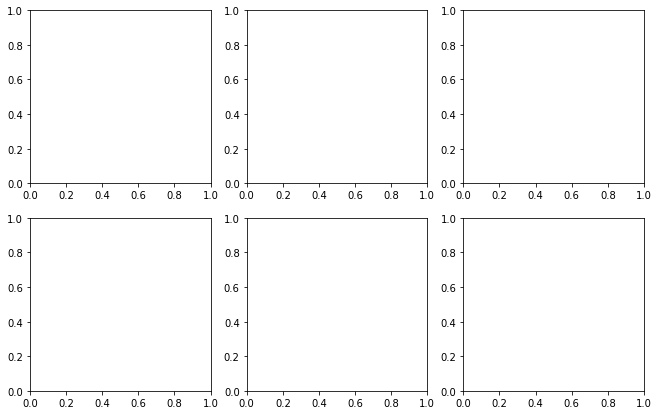

In [170]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier




# TODO: Initialize the three models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(random_state=0)
clf_C = AdaBoostClassifier(random_state=0)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
#samples_10 = int(0.1*samples_100)
#samples_1 = int(0.01*samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [176]:
mix_df.loc[0]

,00s,60s,70s,80s,90s,Hip-Hop,House,Mellow,Progressive rock,acoustic,...,oldies,party,pop,punk,rnb,rock,sad,sexy,soul,Composer
0,0.995,0.358,0.823,0.169,0.525,0.165,0.986,0.573,0.912,0.009,...,0.107,0.183,0.015,0.933,0.108,0.976,0.322,0.838,0.780,Chopin
0,0.961,0.395,0.953,0.349,0.684,0.340,0.981,0.631,0.758,0.016,...,0.043,0.220,0.008,0.820,0.487,0.982,0.761,0.637,0.793,Other


In [179]:
features_raw.loc[0]

,00s,60s,70s,80s,90s,Hip-Hop,House,Mellow,Progressive rock,acoustic,...,metal,oldies,party,pop,punk,rnb,rock,sad,sexy,soul
0,0.995,0.358,0.823,0.169,0.525,0.165,0.986,0.573,0.912,0.009,...,0.423,0.107,0.183,0.015,0.933,0.108,0.976,0.322,0.838,0.780
0,0.961,0.395,0.953,0.349,0.684,0.340,0.981,0.631,0.758,0.016,...,0.165,0.043,0.220,0.008,0.820,0.487,0.982,0.761,0.637,0.793


In [178]:
clf_A.predict(features_raw.loc[0])

array([1, 0])

In [172]:
results

{'AdaBoostClassifier': {0: {'acc_test': 0.75,
   'acc_train': 1.0,
   'f_test': 0.8333333333333334,
   'f_train': 1.0,
   'pred_time': 0.01096963882446289,
   'train_time': 0.08477258682250977}},
 'DecisionTreeClassifier': {0: {'acc_test': 0.75,
   'acc_train': 1.0,
   'f_test': 0.8333333333333334,
   'f_train': 1.0,
   'pred_time': 0.0009982585906982422,
   'train_time': 0.0009987354278564453}},
 'GaussianNB': {0: {'acc_test': 1.0,
   'acc_train': 0.9375,
   'f_test': 1.0,
   'f_train': 0.9183673469387754,
   'pred_time': 0.0019948482513427734,
   'train_time': 0.0019931793212890625}}}

In [166]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state=0)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators':[100,150,200,50],'learning_rate':[0.1,0.3,0.5,0.8,1]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters,scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.7500
F-score on testing data: 0.8333

Optimized Model
------
Final accuracy score on the testing data: 1.0000
Final F-score on the testing data: 1.0000
